# Token prob EDA - 2

In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [22]:
import re
import pickle
import json
import random
from itertools import islice
from pathlib import Path
from dataclasses import dataclass
from typing import List, Tuple, Union, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import vec4gloss
from vec4gloss import check_hashes    
from vec4gloss import (
    DepWinOutput, AnnotDepInfo,
    AnnotFrameInfo, NounFrameInfo
)

## Data dependencies

```
30.23 => ..\data\annot_frameinfo_list.pkl f25b87
30.26 => ..\data\nouns_vec4gloss_frameinfo_list.pkl 9ad739
```

In [3]:
annot_info_path = "../data/annot_frameinfo_list.pkl"
noun_info_path = "../data/nouns_vec4gloss_frameinfo_list.pkl"
_ = check_hashes([annot_info_path, noun_info_path])

..\data\annot_frameinfo_list.pkl f25b87
..\data\nouns_vec4gloss_frameinfo_list.pkl 9ad739


## Load resources

In [4]:
annot_infos = pickle.loads(Path(annot_info_path).read_bytes())
noun_infos = pickle.loads(Path(noun_info_path).read_bytes())

In [5]:
len(annot_infos), len(noun_infos)

(244, 20)

In [6]:
annot_infos[1], noun_infos[1]

(AnnotFrameInfo(annot_frame=AnnotFrame(sense_id=5071201, POS='D', head_word='實地', definition='表親身體驗後述事件。', event_role='patient ', schemas=[Scheme(type='--', start=0, end=1), Scheme(type='mod', start=1, end=3), Scheme(type='action', start=3, end=5), Scheme(type='event', start=5, end=9)]), dep_info=[<AnnotDepInfo (2) 1.00: ( 3- 3) [ 0.00/1.00] 　表 / >, <AnnotDepInfo (3) 0.00: ( 3- 4) [ 0.56/0.00] 　親 / 表>, <AnnotDepInfo (4) 0.91: ( 3- 5) [ 2.32/0.39] 　身 / 表親>, <AnnotDepInfo (5) 0.02: ( 3- 4) [ 1.32/0.01] 　體 / 表>, <AnnotDepInfo (6) 1.00: ( 3- 5) [24604.15/0.00] 　驗 / 表親>, <AnnotDepInfo (7) 0.00: ( 3- 8) [43.86/0.00] 　後 / 表親身體驗>, <AnnotDepInfo (8) 0.02: ( 3- 4) [ 3.26/0.01] 　述 / 表>, <AnnotDepInfo (9) 0.38: ( 7-10) [39.18/0.01] 事件 / 驗後述>]),
 NounFrameInfo(noun_entry={'cwnid': '09167302', 'src': '昨天他派宦官已經暗示過張延賞，今天將由張延賞來挑主<樑>力促此事，但韓卻看破他的企圖，一上來便釜底抽薪，打亂了他地部署。', 'tgt': 'Na。比喻在特定事件中最重要的角色。', 'pos': 'N', 'target': '樑', 'fillers': ['學院', '室友', '弟兄'], 'example': '昨天他派宦官已經暗示過張延賞，今天將由張延賞來挑主<樑>力促此事，但韓卻看破他

In [61]:
class TokenParam:
    def __init__(self, token_dep_info: AnnotDepInfo):
        self.dep_info = token_dep_info
        self.full_prob = token_dep_info.full_token_prob()
        self.masked_prob = token_dep_info.fullmasked_token_prob()
        self.nodep_prob = token_dep_info.nodep_token_prob()
    
    def __repr__(self):
        return "<TokenLambda {:}: p={:.1f}, μ={:.1f}, λ={:.1f}>".format(
            self.token(),
            self.get_token_prob(),
            self.get_mu(),
            self.get_lambda()
        )
    
    def token(self):
        return self.dep_info.dep_wins[0].token_text
    
    def get_mu(self):
        return -np.log(self.masked_prob / self.full_prob)
    
    def get_lambda(self):
        return -np.log(self.nodep_prob / self.full_prob)
    
    def get_token_prob(self):
        return self.full_prob

## Compute token param by each token

In [18]:
TokenStr = str
def compute_token_params_flatten(
        frame_infos:Union[List[AnnotFrameInfo], List[NounFrameInfo]]
        ) -> List[Tuple[TokenStr, int, float, float, float]]:
    params = []
    for frame_x in frame_infos:
        for token_info in frame_x.dep_info:
            token_param = TokenParam(token_info)
            token = token_param.token()
            tok_idx = token_info.tgt_idx
            p_prob = token_param.get_token_prob()
            p_mu = token_param.get_mu()
            p_lambda = token_param.get_lambda()
            params.append((token, tok_idx, p_prob, p_mu, p_lambda))            
            
    return params

In [41]:
import random
rng = random.Random(34)
annot_info_samples = annot_infos[:]
rng.shuffle(annot_info_samples)
adv_token_flattens = compute_token_params_flatten(annot_info_samples[:20])
noun_token_flattens = compute_token_params_flatten(noun_infos)

In [42]:
flatten_cols = "tok,pos,prob,mu,lambda"
adv_flatten_df = pd.DataFrame.from_records(adv_token_flattens, 
                                        columns=flatten_cols.split(","))
noun_flatten_df = pd.DataFrame.from_records(noun_token_flattens, 
                                        columns=flatten_cols.split(","))

In [43]:
adv_token_flattens[:10]

[('表', 3, 0.9955127835273743, -0.0, -0.0),
 ('事件', 4, 0.029469745233654976, 0.5441726936537665, 0.5441726936537665),
 ('的', 5, 0.024639872834086418, -1.2442957616650057, 0.23836038205645038),
 ('規模', 6, 4.915602403343655e-05, 4.561587074751502, 5.316292947862595),
 ('或', 7, 0.7812301516532898, 3.4306012241885013, 3.5815861727293097),
 ('程度', 8, 0.9963523149490356, 7.891175366070348, 9.824569094855907),
 ('高', 9, 0.08984841406345367, -1.4972782176589667, 2.619336582856843),
 ('表', 2, 0.9858243465423584, -0.0, -0.0),
 ('事件', 3, 0.0067185303196311, 0.06990102680795865, 0.06990102680795865),
 ('有可能', 4, 0.014280990697443485, 3.750382715974653, 3.750382715974653)]

In [44]:
adv_flatten_df.query("prob>0.9 & pos>5").mean(numeric_only=True)

pos       9.666667
prob      0.980958
mu        3.981328
lambda    6.284941
dtype: float64

In [45]:
noun_flatten_df.query("prob>0.9 & pos>5").mean(numeric_only=True)

pos       11.470588
prob       0.987885
mu         3.344628
lambda     5.138210
dtype: float64

<AxesSubplot:ylabel='Density'>

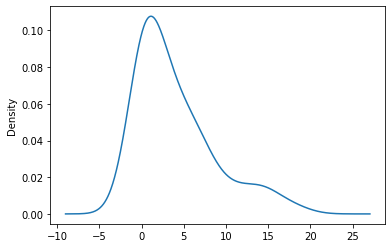

In [46]:
adv_flatten_df.query("prob>0.9 & pos>5").mu.plot.kde()

<AxesSubplot:ylabel='Density'>

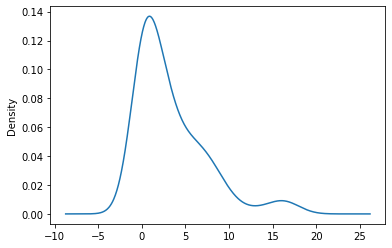

In [47]:
noun_flatten_df.query("prob>0.9 & pos>5").mu.plot.kde()

In [62]:
token_params = [TokenParam(x) for x in noun_infos[10].dep_info]

In [65]:
noun_infos[10]

NounFrameInfo(noun_entry={'cwnid': '10010601', 'src': '<異質性>團隊的重要性，一個團隊的成員如果都是不同特質的人所組成，其產生的團隊績效將最大的。', 'tgt': 'Na。特定對象可與其他同類對象顯現出明顯差異並有區辨性的性質。', 'pos': 'N', 'target': '異質性', 'fillers': ['之內', '反應', '素'], 'example': '<異質性>團隊的重要性，一個團隊的成員如果都是不同特質的人所組成，其產生的團隊績效將最大的。', 'from': 'vec4gloss', 'definition': '形容具有多個性質或性質的。', 'item_id': 'N-15'}, dep_info=[<AnnotDepInfo (2) 0.01: ( 3- 3) [ 0.00/0.01] 特定 / >, <AnnotDepInfo (3) 0.69: ( 3- 4) [ 0.88/0.78] 　對 / 特定>, <AnnotDepInfo (4) 1.00: ( 3- 4) [5195.16/0.00] 　象 / 特定>, <AnnotDepInfo (5) 0.00: ( 3- 5) [3013.39/0.00] 　可 / 特定對>, <AnnotDepInfo (6) 0.02: ( 3- 7) [ 4.78/0.00] 　與 / 特定對象可>, <AnnotDepInfo (7) 0.73: ( 3- 7) [18.80/0.04] 其他 / 特定對象可>, <AnnotDepInfo (8) 0.59: ( 7- 9) [ 4.65/0.13] 　同 / 與其他>, <AnnotDepInfo (9) 1.00: ( 7-10) [ 1.06/0.95] 　類 / 與其他同>, <AnnotDepInfo (10) 1.00: ( 6-11) [83414.00/0.00] 　對 / 可與其他同類>, <AnnotDepInfo (11) 1.00: ( 7-12) [331.03/0.00] 　象 / 與其他同類對>, <AnnotDepInfo (12) 0.00: ( 6- 7) [55.38/0.00] 　顯 / 可>, <AnnotDepInfo (13) 0.

In [63]:
token_params

[<TokenLambda 特定: p=0.0, μ=-0.0, λ=-0.0>,
 <TokenLambda 對: p=0.7, μ=-0.1, λ=-0.1>,
 <TokenLambda 象: p=1.0, μ=8.1, λ=8.6>,
 <TokenLambda 可: p=0.0, μ=3.8, λ=8.0>,
 <TokenLambda 與: p=0.0, μ=1.6, λ=1.6>,
 <TokenLambda 其他: p=0.7, μ=2.7, λ=2.9>,
 <TokenLambda 同: p=0.6, μ=0.3, λ=1.5>,
 <TokenLambda 類: p=1.0, μ=0.0, λ=0.1>,
 <TokenLambda 對: p=1.0, μ=8.1, λ=11.3>,
 <TokenLambda 象: p=1.0, μ=0.0, λ=5.8>,
 <TokenLambda 顯: p=0.0, μ=1.1, λ=4.0>,
 <TokenLambda 現: p=0.7, μ=1.3, λ=5.1>,
 <TokenLambda 出: p=0.9, μ=7.5, λ=9.7>,
 <TokenLambda 明: p=0.0, μ=4.9, λ=4.9>,
 <TokenLambda 顯: p=1.0, μ=0.1, λ=1.4>,
 <TokenLambda 差: p=0.8, μ=10.7, λ=11.1>,
 <TokenLambda 異: p=1.0, μ=0.0, λ=1.8>,
 <TokenLambda 並: p=0.0, μ=7.1, λ=9.4>,
 <TokenLambda 有: p=0.1, μ=0.5, λ=2.2>,
 <TokenLambda 區: p=0.0, μ=3.7, λ=5.0>,
 <TokenLambda 辨: p=0.1, μ=5.9, λ=5.9>,
 <TokenLambda 性的: p=0.8, μ=7.8, λ=9.8>,
 <TokenLambda 性質: p=0.5, μ=0.5, λ=0.7>]